In [39]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys 
# sys.path.append("/Users/julianganzabal/facultad/lab-ml/mllab-tools")
from RNN_utils import encode_io_pairs, chars_to_one_hot, sample
from fnn_helper import PlotLosses

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Elegimos una palabra que tenga una letra repetida

In [40]:
text="HELLO"

In [41]:
chars = sorted(set(text))
print(chars)

['E', 'H', 'L', 'O']


In [42]:
window_size=1
chars_to_indices = dict((c, i) for i, c in enumerate(chars))  # map each unique character to unique integer
indices_to_chars = dict((i, c) for i, c in enumerate(chars))

## Texto a One-hot

In [43]:
chars_to_one_hot(text, chars, chars_to_indices, window_size)*1

array([[[0, 1, 0, 0],
        [1, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]]])

## One-hot a caracter

In [44]:
print(indices_to_chars[np.argmax([1, 0, 0, 0])])
print(indices_to_chars[np.argmax([0, 1, 0, 0])])

E
H


## Preparo entrada/salida:  
### N=4, T=1, D=4

In [45]:
window_size = 1
step_size = 1
X, y = encode_io_pairs(text, chars, window_size, step_size)

In [46]:
print('X:', X.shape, 'y:', y.shape)

X: (4, 1, 4) y: (4, 4)


In [47]:
print(X*1)

[[[0 1 0 0]]

 [[1 0 0 0]]

 [[0 0 1 0]]

 [[0 0 1 0]]]


In [48]:
print(y*1)

[[1 0 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]]


Notar que la salida es el siguiente caracter al de la entrada

Esto es equivalente a un MLP

### Armo modelo RNN

In [49]:
from keras.layers import SimpleRNN, Dense
from keras.models import Sequential

In [50]:
model = Sequential()
model.add(SimpleRNN(10, input_shape=(window_size,len(chars))))
model.add(Dense(len(chars), activation="softmax"))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_5 (SimpleRNN)     (None, 10)                150       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 44        
Total params: 194
Trainable params: 194
Non-trainable params: 0
_________________________________________________________________


### Entreno el modelo

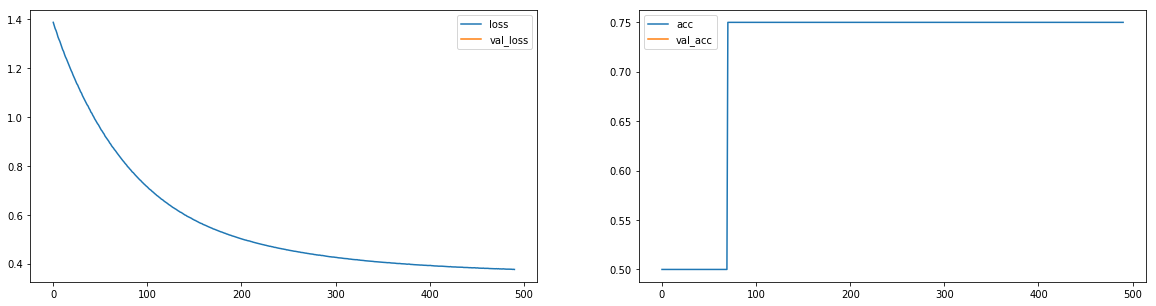

4/4 [==============================] - 0s 90ms/step - loss: 0.3767 - acc: 0.7500
Epoch 492/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3767 - acc: 0.7500
Epoch 493/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3771 - acc: 0.7500
Epoch 494/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3765 - acc: 0.7500
Epoch 495/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3765 - acc: 0.7500
Epoch 496/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3766 - acc: 0.7500
Epoch 497/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3766 - acc: 0.7500
Epoch 498/500
4/4 [==============================] - 0s 5ms/step - loss: 0.3761 - acc: 0.7500
Epoch 499/500
4/4 [==============================] - 0s 4ms/step - loss: 0.3758 - acc: 0.7500
Epoch 500/500
4/4 [==============================] - 0s 3ms/step - loss: 0.3757 - acc: 0.7500


In [51]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model.fit(X,y, epochs=500, batch_size=1, verbose=1, callbacks=[plot_losses])

Por que no llega al 100%? Que es lo que no puede predecir?

### Predicción usando argmax

In [52]:
char_to_predict = text[0]
to_predict = chars_to_one_hot(char_to_predict, chars, chars_to_indices, window_size)*1
print(char_to_predict, '=', to_predict)
predicted = model.predict(to_predict)
print(predicted)
print(indices_to_chars[np.argmax(predicted)])

H = [[[0 1 0 0]]]
[[ 0.97909808  0.00642824  0.00343458  0.01103912]]
E


### Predicción muestrando
#### Ejemplo generico

In [53]:
# probar con temperaturas 0.1, 1, 10
temperature = 1
probabilities = [0.4, 0.1, 0.5]
for i in range(5):
    print(sample(probabilities, temperature, verbose=True))

[ 0.4  0.1  0.5]
0
[ 0.4  0.1  0.5]
0
[ 0.4  0.1  0.5]
0
[ 0.4  0.1  0.5]
2
[ 0.4  0.1  0.5]
2


### Ejemplo con caracteres aprendidos

In [54]:
to_predict = chars_to_one_hot(char_to_predict, chars, chars_to_indices, window_size)*1
predicted = model.predict(to_predict)
print('predicted probs:',predicted)
iterat = 100
temp = 1 # 1, 0.5, 0.1, 0.01
results = []
for i in range(iterat):
    results.append(indices_to_chars[sample(predicted[0], temp)])
print(results)

predicted probs: [[ 0.97909808  0.00642824  0.00343458  0.01103912]]
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'H', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']


In [61]:
chars_to_predict = text[:4]
print(chars_to_predict)
# Los paso a one hot
to_predict = chars_to_one_hot(chars_to_predict, chars, chars_to_indices, window_size)*1
print(to_predict)
print(to_predict.shape)

HELL
[[[0 1 0 0]
  [1 0 0 0]
  [0 0 1 0]
  [0 0 1 0]]]
(1, 4, 4)


In [59]:
# Tengo que hacer reshape para darselo a la red
to_predict.reshape(4,1,4)

array([[[0, 1, 0, 0]],

       [[1, 0, 0, 0]],

       [[0, 0, 1, 0]],

       [[0, 0, 1, 0]]])

In [62]:
predicted = model.predict(to_predict.reshape(4,1,4))
print(predicted)
for i, row in enumerate(predicted):
    print(indices_to_chars[np.argmax(to_predict[:,i])], row, indices_to_chars[np.argmax(row)])

[[ 0.97909808  0.00642824  0.00343458  0.01103912]
 [ 0.01121183  0.01210679  0.92534226  0.05133909]
 [ 0.00385837  0.00344079  0.51158988  0.48111102]
 [ 0.00385837  0.00344079  0.51158988  0.48111102]]
H [ 0.97909808  0.00642824  0.00343458  0.01103912] E
E [ 0.01121183  0.01210679  0.92534226  0.05133909] L
L [ 0.00385837  0.00344079  0.51158988  0.48111102] L
L [ 0.00385837  0.00344079  0.51158988  0.48111102] L


Notar que la L tiene alta probabilidad tanto para la 'L' como la 'O'

## T = 2

In [63]:
window_size = 2
X_2, y_2 = encode_io_pairs(text, chars, window_size, step_size)

In [66]:
print(X_2*1)

[[[0 1 0 0]
  [1 0 0 0]]

 [[1 0 0 0]
  [0 0 1 0]]

 [[0 0 1 0]
  [0 0 1 0]]]


In [68]:
print(y_2*1)

[[0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]]


In [69]:
model_2 = Sequential()
model_2.add(SimpleRNN(10, input_shape=(window_size,len(chars))))
model_2.add(Dense(len(chars), activation="softmax"))
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_7 (SimpleRNN)     (None, 10)                150       
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 44        
Total params: 194
Trainable params: 194
Non-trainable params: 0
_________________________________________________________________


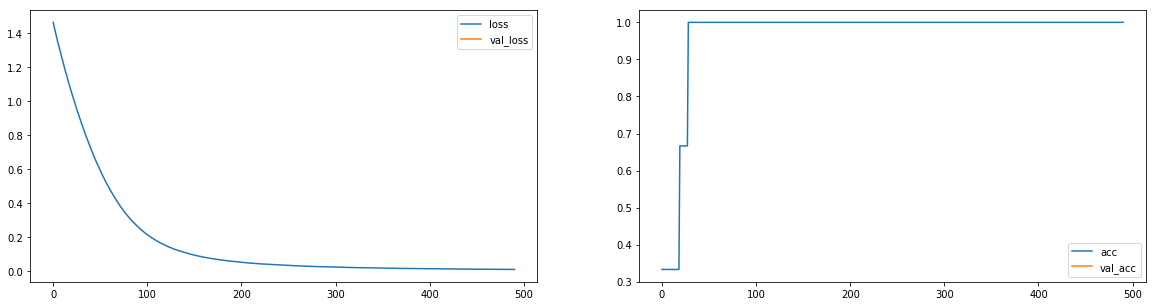

3/3 [==============================] - 0s 112ms/step - loss: 0.0081 - acc: 1.0000
Epoch 492/500
3/3 [==============================] - 0s 4ms/step - loss: 0.0081 - acc: 1.0000
Epoch 493/500
3/3 [==============================] - 0s 4ms/step - loss: 0.0080 - acc: 1.0000
Epoch 494/500
3/3 [==============================] - 0s 4ms/step - loss: 0.0080 - acc: 1.0000
Epoch 495/500
3/3 [==============================] - 0s 4ms/step - loss: 0.0080 - acc: 1.0000
Epoch 496/500
3/3 [==============================] - 0s 4ms/step - loss: 0.0079 - acc: 1.0000
Epoch 497/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0079 - acc: 1.0000
Epoch 498/500
3/3 [==============================] - 0s 4ms/step - loss: 0.0079 - acc: 1.0000
Epoch 499/500
3/3 [==============================] - 0s 5ms/step - loss: 0.0078 - acc: 1.0000
Epoch 500/500
3/3 [==============================] - 0s 4ms/step - loss: 0.0078 - acc: 1.0000


In [70]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
plot_losses = PlotLosses(plot_interval=10, evaluate_interval=None)
model_2.fit(X_2,y_2, epochs=500, batch_size=1, verbose=1, callbacks=[plot_losses])

In [71]:
print(X_2*1)
predicted = model_2.predict(X_2)
for i, row in enumerate(predicted):
    print(indices_to_chars[np.argmax(X_2[i, 0])]+indices_to_chars[np.argmax(X_2[i, 1])], row, indices_to_chars[np.argmax(row)])

[[[0 1 0 0]
  [1 0 0 0]]

 [[1 0 0 0]
  [0 0 1 0]]

 [[0 0 1 0]
  [0 0 1 0]]]
HE [  1.67074206e-03   8.92872922e-04   9.95965958e-01   1.47038407e-03] L
EL [ 0.00222264  0.00161437  0.99297911  0.00318391] L
LL [ 0.0060816   0.002143    0.00397838  0.98779696] O


- Las probabilidades son practicamente 1
- La cantidad de parametros de la red no cambia respecto a la anterior
- Que pasa si lo implemento con MLP con la cantidad de parámetros?

### Redefino Modelo con pesos aprendidos pero statefull

In [97]:
batch_size=1
model_2_p = Sequential()
model_2_p.add(SimpleRNN(10, batch_input_shape=(batch_size,1,len(chars)), stateful=True))
model_2_p.add(Dense(len(chars), activation="softmax"))
model_2_p.summary()
model_2_p.set_weights(model_2.get_weights())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_12 (SimpleRNN)    (1, 10)                   150       
_________________________________________________________________
dense_12 (Dense)             (1, 4)                    44        
Total params: 194
Trainable params: 194
Non-trainable params: 0
_________________________________________________________________


In [105]:
window_size=1
model_2_p.reset_states()
to_predict = chars_to_one_hot('H', chars, chars_to_indices, window_size)*1
predicted = model_2_p.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.23475175  0.11805256  0.34657958  0.30061609]]


'L'

Notar que con un solo caracter ingresado, no tiene suficiente para predecir (Ningun caracter tiene alta probabilidad)

In [106]:
to_predict = chars_to_one_hot('E', chars, chars_to_indices, window_size)*1
predicted = model_2_p.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[  1.67074206e-03   8.92872922e-04   9.95965958e-01   1.47038407e-03]]


'L'

Notar ahor que la 'L' si tiene alta probabilidad

In [107]:
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_2_p.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[  1.92920433e-03   6.31663832e-04   9.93274450e-01   4.16464824e-03]]


'L'

In [109]:
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_2_p.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.00816088  0.00196393  0.89888704  0.09098819]]


'L'

Notar también que si me paso de la cantidad de caracteres con los que entrene no tengo ninguna garantia de que hará una buena predicción

Por eso, si quiero predecir una nueva secuencia de dos, tengo que resetear el estado y luego  mandar un caracter y luego el otro

In [119]:
model_2_p.reset_states()
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_2_p.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.02643706  0.03520635  0.46277788  0.4755787 ]]


'O'

In [120]:
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_2_p.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.0060816   0.002143    0.00397838  0.98779696]]


'O'

# Stateful RNN
Entreno en modo statefull

In [124]:
batch_size=1
model_3 = Sequential()
model_3.add(SimpleRNN(10, batch_input_shape=(batch_size,1,len(chars)), stateful=True))
model_3.add(Dense(len(chars), activation="softmax"))
model_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_14 (SimpleRNN)    (1, 10)                   150       
_________________________________________________________________
dense_14 (Dense)             (1, 4)                    44        
Total params: 194
Trainable params: 194
Non-trainable params: 0
_________________________________________________________________


In [125]:
X.shape

(4, 1, 4)

In [126]:
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
for i in range(300):
    model_3.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
    model_3.reset_states()

Epoch 1/1
4/4 [==============================] - 0s 94ms/step - loss: 1.2923 - acc: 0.0000e+00
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 1.2781 - acc: 0.0000e+00
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 1.2656 - acc: 0.0000e+00
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 1.2533 - acc: 0.0000e+00
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 1.2411 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 1.2291 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 1.2172 - acc: 0.5000
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 1.2056 - acc: 0.5000
Epoch 1/1
4/4 [==============================] - 0s 5ms/step - loss: 1.1942 - acc: 0.5000
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 1.1831 - acc: 0.5000
Epoch 1/1
4/4 [==============================] - 0s 4ms/step - loss: 1.1721 - acc: 

# Voy ingresando de a uno

In [127]:
window_size=1
model_3.reset_states()
to_predict = chars_to_one_hot('H', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.87270081  0.01994307  0.06463003  0.04272606]]


'E'

In [128]:
to_predict = chars_to_one_hot('E', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.08663546  0.01045904  0.89792258  0.00498293]]


'L'

In [129]:
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.01488155  0.00855262  0.94289589  0.03366999]]


'L'

In [130]:
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.01187373  0.00687308  0.10068052  0.88057262]]


'O'

Algunas pruebas mas

In [131]:
# Intento predecir q vendra despues de la L pero sin una secuencia antes
model_3.reset_states()
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
indices_to_chars[np.argmax(predicted[0])]

[[ 0.02435183  0.00653726  0.05879242  0.91031855]]


'O'

In [132]:
# Comparo probs con una L contra LL
model_3.reset_states()
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
print(indices_to_chars[np.argmax(predicted[0])])

to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted)
print(indices_to_chars[np.argmax(predicted[0])])

[[ 0.02435183  0.00653726  0.05879242  0.91031855]]
O
[[  2.74139224e-03   5.41602785e-04   1.16519001e-03   9.95551765e-01]]
O


In [133]:
# Interesante! HEL -> L, pero EL -> O (No es markov de primer orden. Necesita tambien el orden anterior)
model_3.reset_states()
to_predict = chars_to_one_hot('E', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted, indices_to_chars[np.argmax(predicted[0])])
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted, indices_to_chars[np.argmax(predicted[0])])

[[ 0.04864763  0.01476993  0.61417139  0.32241103]] L
[[ 0.00197383  0.00107667  0.01708973  0.97985977]] O


In [142]:
# Que predice si ingreso con ceros?
model_3.reset_states()
predicted = model_3.predict(np.array([[[0, 0, 0, 0]]]))
print(predicted, indices_to_chars[np.argmax(predicted[0])])

[[ 0.20176999  0.040487    0.25552493  0.50221807]] O


In [135]:
model_3.reset_states()
to_predict = chars_to_one_hot('H', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted, indices_to_chars[np.argmax(predicted[0])])
to_predict = chars_to_one_hot('E', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted, indices_to_chars[np.argmax(predicted[0])])
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted, indices_to_chars[np.argmax(predicted[0])])
to_predict = chars_to_one_hot('L', chars, chars_to_indices, window_size)*1
predicted = model_3.predict(to_predict)
print(predicted, indices_to_chars[np.argmax(predicted[0])])

[[ 0.87270081  0.01994307  0.06463003  0.04272606]] E
[[ 0.08663546  0.01045904  0.89792258  0.00498293]] L
[[ 0.01488155  0.00855262  0.94289589  0.03366999]] L
[[ 0.01187373  0.00687308  0.10068052  0.88057262]] O


# Cambio batch size

In [150]:
X_4 = X
y_4 = y
print(X_4.shape)
batch_size=len(X)
print(batch_size)
model_4 = Sequential()
model_4.add(SimpleRNN(10, batch_input_shape=(batch_size,1,len(chars)), stateful=True))
model_4.add(Dense(len(chars), activation="softmax"))
model_4.summary()

(4, 1, 4)
4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_17 (SimpleRNN)    (4, 10)                   150       
_________________________________________________________________
dense_17 (Dense)             (4, 4)                    44        
Total params: 194
Trainable params: 194
Non-trainable params: 0
_________________________________________________________________


In [145]:
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#for i in range(1000):
model_4.fit(X_4, y_4, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
#model_4.reset_states()

Epoch 1/1
4/4 [==============================] - 0s 101ms/step - loss: 1.4191 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s 807us/step - loss: 1.4146 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s 851us/step - loss: 1.4086 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s 1ms/step - loss: 1.4027 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s 1ms/step - loss: 1.3967 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s 809us/step - loss: 1.3908 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s 994us/step - loss: 1.3849 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s 860us/step - loss: 1.3790 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s 968us/step - loss: 1.3732 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s 898us/step - loss: 1.3674 - acc: 0.2500
Epoch 1/1
4/4 [==============================] - 0s 664us/step - loss: 1.3616 - acc:

In [93]:
model_4.reset_states()
to_predict = chars_to_one_hot('H', chars, chars_to_indices, window_size)*1
predicted = model_4.predict(to_predict)
print(predicted)
print(indices_to_chars[np.argmax(predicted[0])])
to_predict = chars_to_one_hot('E', chars, chars_to_indices, window_size)*1
predicted = model_4.predict(to_predict)
print(predicted)
print(indices_to_chars[np.argmax(predicted[0])])

ValueError: Cannot feed value of shape (1, 1, 4) for Tensor 'simple_rnn_11_input:0', which has shape '(4, 1, 4)'

# TimeDistributed wrapper
https://machinelearningmastery.com/timedistributed-layer-for-long-short-term-memory-networks-in-python/

# Pad sequences
"The model will learn the zero values carry no information so indeed the sequences are not the same length in terms of content, but same length vectors is required to perform the computation in Keras."
https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

https://machinelearningmastery.com/understanding-stateful-lstm-recurrent-neural-networks-python-keras/

# Encoder decoder
https://machinelearningmastery.com/encoder-decoder-long-short-term-memory-networks/

# Sentiment analysis con CNN y LSTM
https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

# Word-level language model

https://machinelearningmastery.com/how-to-develop-a-word-level-neural-language-model-in-keras/

# return_sequence vs return_state
https://www.quora.com/What-is-the-difference-between-states-and-outputs-in-LSTM

https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/

# Truncated BPTT 
https://machinelearningmastery.com/truncated-backpropagation-through-time-in-keras/